# 🔍 Riesgo de Lesión (v6) - Análisis Visual del Modelo
Este notebook amplía el análisis del modelo de riesgo de lesión incluyendo gráficas avanzadas para facilitar la interpretación de resultados, la comunicación con entrenadores y la justificación de decisiones técnicas.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar y preparar datos
df = pd.read_csv('data/concat/df_final.csv')
df['FECHA_DT'] = pd.to_datetime(df['FECHA'], errors='coerce', dayfirst=True)
df = df.sort_values(['ATLETA', 'FECHA_DT'])

# Calcular variables
df['CARGA'] = df['PSE'] * df['TIEMPO']
df['DÍAS_CONSECUTIVOS'] = df.groupby('ATLETA')['FECHA_DT'].diff().dt.days.fillna(0).ne(1).cumsum()
df['ACWR'] = df.groupby('ATLETA')['CARGA'].transform(
    lambda x: x.rolling(7, min_periods=1).mean() / x.rolling(28, min_periods=1).mean())

# Clasificación más flexible
def clasificar_riesgo(row):
    if pd.isna(row['ACWR']) or pd.isna(row['DOLOR']): return None
    if row['ACWR'] > 1.3 and row['DOLOR'] >= 2: return 2
    elif row['ACWR'] > 1.1: return 1
    else: return 0

df['riesgo_lesion'] = df.apply(clasificar_riesgo, axis=1)

# Imputación
df['SUEÑO'] = df['SUEÑO'].fillna(df['SUEÑO'].median())
df['DOLOR'] = df['DOLOR'].fillna(df['DOLOR'].median())
df['ACWR'] = df['ACWR'].fillna(1.0)
df['CARGA'] = df['CARGA'].fillna(0)

C:\Users\anavarro\AppData\Local\Temp\ipykernel_7048\3803533675.py:2: DtypeWarning: Columns (12,18,23,24,25,27,29,31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/concat/df_final.csv')


In [3]:
# División y entrenamiento con SMOTE
features = ['CARGA', 'ACWR', 'DOLOR', 'SUEÑO', 'DÍAS_CONSECUTIVOS']
df_model = df.dropna(subset=features + ['riesgo_lesion'])
X = df_model[features]
y = df_model['riesgo_lesion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_resampled, y_resampled)
y_pred = modelo.predict(X_test)

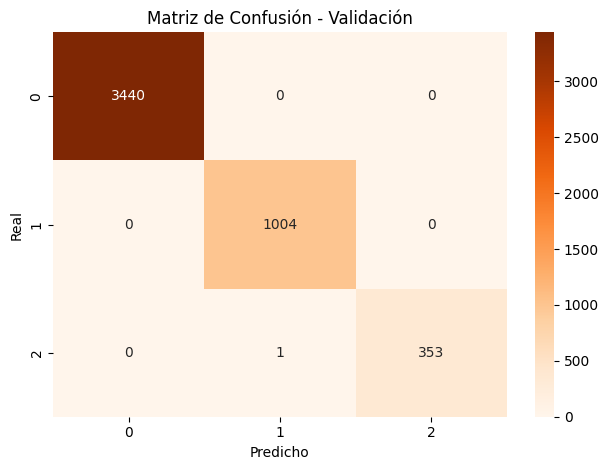

In [4]:
# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Confusión - Validación')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

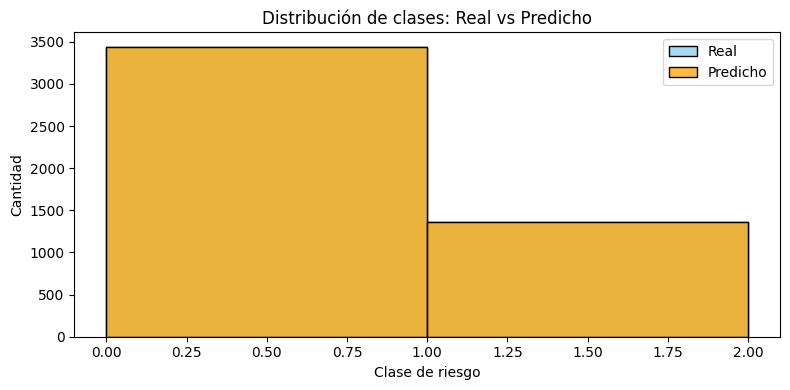

In [5]:
# Comparación de clases reales vs predichas
plt.figure(figsize=(8,4))
sns.histplot(y_test, color='skyblue', label='Real', kde=False, binwidth=1)
sns.histplot(y_pred, color='orange', label='Predicho', kde=False, binwidth=1)
plt.legend()
plt.title('Distribución de clases: Real vs Predicho')
plt.xlabel('Clase de riesgo')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

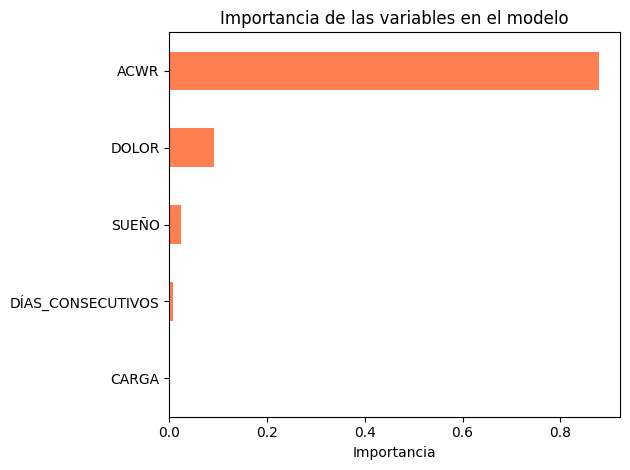

In [6]:
# Importancia de variables en el modelo
importancia = pd.Series(modelo.feature_importances_, index=X.columns)
importancia.sort_values().plot(kind='barh', color='coral')
plt.title('Importancia de las variables en el modelo')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

## 🧠 Interpretación avanzada de resultados
- **Distribución real vs predicha** permite detectar si el modelo sobrestima alguna clase.
- **Importancia de variables** justifica técnicamente qué variables influyen más en la predicción del riesgo.
- Estos gráficos pueden integrarse al **dashboard o reporte PDF diario**.

🔍 Para cada deportista, puedes aplicar filtros como:
```python
df[df['ATLETA'] == 'Nombre del atleta']
```
Y aplicar `modelo.predict()` sobre sus datos para analizar su evolución de riesgo.